# Forward Process

In [1]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import ToPILImage
from IPython.display import display
import math
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:
# Beta scheduling

def linear_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    return torch.linspace(start, end, timesteps)


def cosine_beta_schedule(timesteps, start = 0.0001, end = 0.02):
    betas = torch.linspace(0, 1, timesteps)
    betas = 0.5 * (1 + torch.cos(betas * math.pi))
    betas = start + (end - start) * betas
    return betas

In [3]:
# Timesteps T & beta 

T = 100
# betas = linear_beta_schedule(timesteps=T)
betas = cosine_beta_schedule(timesteps=T)

In [4]:
alphas = 1 - betas # alpha & beta
alphas_cumprod = torch.cumprod(alphas, axis=0) # \Pi alpha = alpha x alpha ...
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value = 1) # timestep t cumprod alpha = timestep {t-1} cumprod alpha x t step alpha
sqrt_recip_alphas = torch.sqrt(1.0 / alphas) # 1 / alpha = noise의 variance
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod) # alphas_cumprod: noise 크기의 누적 변화 (\Pi alpha)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod) # root 1-cumprod alpha
posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod) # noise variance에 따른 posterior variance. reconstruction에 사용

In [5]:
'''
특정 timestep t에서의 값을 가져오기 위한 장치
vals: timestep에 다라 변하는 값을 가진 리스트 (2차원)
t: 특정 timestep의 시간을 나타내는 tensor (2차원)
'''
def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0] # t는 embedding된 timestep의 tensor
    out = vals.gather(-1, t.cpu())  # t에 해당하는 값을 가져옴.
    
    return out.reshape(batch_size, *((1, ) * (len(x_shape) - 1))).to(t.device) # out tensor의 형태를 조정. (batch_size, 1,1,1,...,1) 로 바꿔서 x_0와 동일한 형태


# x_0와 timestep T를 input으로 받고 noise로 만들기
def forward_diffusion_sample(x_0, t, device="cpu"):
    
    noise = torch.randn_like(x_0)  
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)


In [7]:
# Data loader
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

def load_transformed_dataset():
    datat_transforms = [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lamdba(lambda t: (t * 2) - 1) # scale between [-1, 1]
    ]
    
    data_transforms = transforms.Compose(datat_transforms)
    
    return data_transforms

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.0),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage()
    ])
    
    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0]
    plt.imshow(reverse_transforms(image))

In [8]:
x_0 = Image.open('image_1.JPEG')
x_0 = transforms.Resize((256, 256))(x_0)
x_0 = transforms.ToTensor()(x_0)
x_0 = transforms.Lambda(lambda t: (t * 2) -1)(x_0) # scale between [-1, 1]

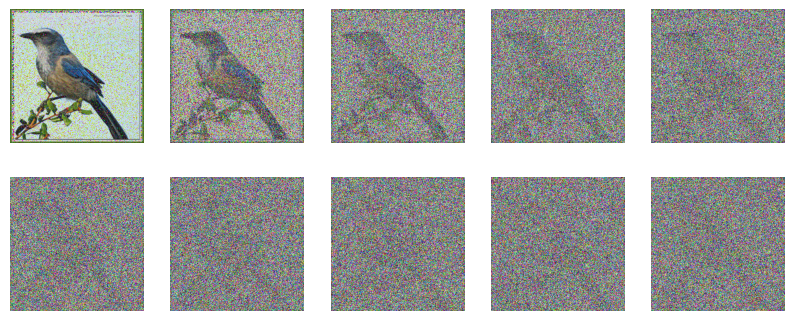

In [14]:
plt.figure(figsize = (10, 4))  
num_images = 10
stepsize = int(T / num_images)
x_t = []


for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(2, num_images // 2, int(idx / stepsize) + 1) 
    plt.axis('off')  
    img, noise = forward_diffusion_sample(x_0, t)
    show_tensor_image(img)
    x_t = img


In [10]:
x_T = x_t[-1]

In [ ]:
# x_0 = x_0.unsqueeze(0) # add batch dimension

In [ ]:
# T = 500  # total timesteps 다시 정의
# interval = T // 10  # 중간에 10개 이미지 뽑아내기 

# noisy_images = []

# for t in range(0, T, interval):
#     # 노이즈 계산
#     noise = sqrt_recip_alphas[t] * np.random.normal(size=x_0.shape) 
    
#     x_t = np.sqrt(alphas_cumprod[t]) * x_0 + np.sqrt(1 - alphas_cumprod[t]) * noise
#     noisy_images.append(x_t)

# # Clip the image data
# clipped_images = [np.clip(img, 0, 1) for img in noisy_images] 

# # Plot the clipped images
# fig, axes = plt.subplots(1, len(clipped_images), figsize=(20, 20))
# for i, img in enumerate(clipped_images):
#     axes[i].imshow(img)
#     axes[i].axis('off')
#     axes[i].set_title(f'Time step {i * interval}')
# plt.show()

In [ ]:
# # 최종적인 noisy image를 x_T로 정의
# x_T = noisy_images[-1]

# Reverse Process
### Original Denoising :
$$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar \alpha_t}} * noise) + \sigma_t z$$


### $x_0$를 condition: 
$$x_{t-1} = x_t + \sqrt(\alpha_t) * noise + \sqrt(1 - \alpha_t) * (x_0 - x_t)$$

In [15]:
def reverse_diffusion_sample(x_t, t, noise, z, device="cpu"):
    sqrt_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x_t.shape) # 1/alpha_t
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_t.shape
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x_t.shape)

    # term1
    term1 = (sqrt_alphas_t.to(device) * x_t.to(device)) - (sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device))
    
    # term2
    term2 = torch.sqrt(posterior_variance_t.to(device)) * z.to(device)
    
    return term1 + term2


In [11]:
# def reverse_process(x, T, alphas, alphas_cumprod, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance):
    
#     reversed_images = [x]
    
#     for t in reversed(range(T)):
#         # posterior mean and variance
#         posterior_mean = sqrt_alphas_cumprod[t] * x
#         # Sample noise from the posterior
#         noise = torch.normal(mean=posterior_mean, std=torch.sqrt(posterior_variance[t]))
#         # x 값에 노이즈를 추가하면서 업데이트
#         x = x + sqrt_alphas_cumprod[t] * noise
#         # Store the image
#         if t % stepsize == 0:
#             reversed_images.append(x.detach().cpu().numpy())
            
#     return reversed_images


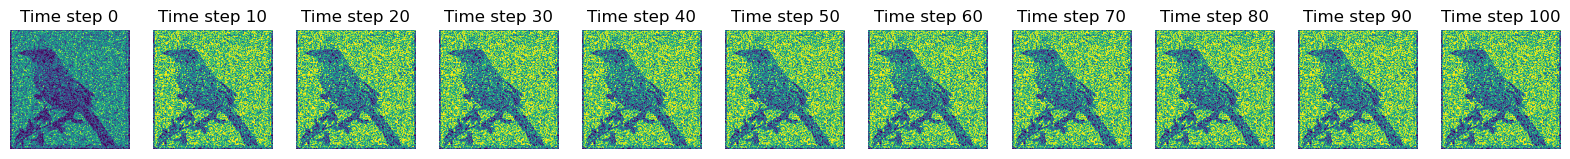

In [13]:
# Reverse process
reversed_images = reverse_process(x_T, T, alphas, alphas_cumprod, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance)

# 최종 reversed image = new_x
new_x = reversed_images[-1]

# Clip images to be in range [0,1]
clipped_images = [np.clip(img, 0, 1) for img in reversed_images]

# Plot the reversed images
fig, axes = plt.subplots(1, len(clipped_images), figsize=(20, 20))
for i, img in enumerate(clipped_images, start=1):  
    axes[i-1].imshow(img)
    axes[i-1].axis('off')
    axes[i-1].set_title(f'Time step {(i-1) * stepsize}')  
plt.show()


## $x_0$ condition sampling

In [ ]:
# x_0 tensor 변환
x_0 = torch.tensor(x_0)

In [ ]:
def reverse_process_with_x0(x, x_0, T, alphas, alphas_cumprod, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance):
    
    reversed_images = [x]
    
    for t in reversed(range(T)):
        # posterior mean and variance
        posterior_mean = sqrt_alphas_cumprod[t] * x
        # Sample noise from the posterior
        noise = torch.normal(mean=posterior_mean, std=torch.sqrt(posterior_variance[t]))
        # x 값에 노이즈를 추가하면서 업데이트
        x = x + sqrt_alphas_cumprod[t] * noise + sqrt_one_minus_alphas_cumprod[t] * (x_0 - x)
        # Store the image
        if t % interval == 0:
            reversed_images.append(x.detach().cpu().numpy())
            
    return reversed_images

In [ ]:
# Reverse process with x_0 as the condition
reversed_images_with_x0 = reverse_process_with_x0(x_T, x_0, T, alphas, alphas_cumprod, sqrt_recip_alphas, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, posterior_variance)

# 최종 reversed image = new_x_with_x0
new_x_with_x0 = reversed_images_with_x0[-1]

# Clip images to be in range [0,1]
clipped_images_with_x0 = [np.clip(img, 0, 1) for img in reversed_images_with_x0]

# Plot the reversed images
fig, axes = plt.subplots(1, len(clipped_images_with_x0), figsize=(20, 20))
for i, img in enumerate(clipped_images_with_x0, start=1):  
    axes[i-1].imshow(img)
    axes[i-1].axis('off')
    axes[i-1].set_title(f'Time step {(i-1) * interval}')  
plt.show()
